In [1]:
from cideMOD import (
    CellParser,
    ErrorCheck,
    NDProblem,
    Problem,
    SolverCrashed,
    Trigger,
    init_results_folder,
    ModelOptions,
)
import numpy as np

In [2]:
overwrite = True
case = "dfn_94"
data_path = "../../data/data_{}".format(case)
params = "params.json"

model_options = ModelOptions(mode='P2D', clean_on_exit=False)

In [3]:
reference = dict()
for I in [30,40,50]:
    reference[f'{I}A/m^2']= np.genfromtxt(f'{data_path}/results_V_{I}A_m2.txt')

In [4]:
cell = CellParser(params, data_path=data_path)
results = dict()
for I in [30,40,50]:
    save_path = init_results_folder(
        case, overwrite=overwrite, copy_files=[f"{data_path}/{params}"]
    )
    problem = Problem(cell, model_options, save_path=save_path)
    problem.set_cell_state(1, 273 + 25, 273 + 25)
    problem.setup()
    I_app = -cell.area*I
    t_f = 3600*2
    v_min = Trigger(2, "v")
    status = problem.solve_ie(
        min_step=5, i_app=I_app, t_f=t_f, store_delay=10, adaptive=True, triggers=[v_min]
    )
    err = ErrorCheck(problem, status)
    results[f'{I}A/m^2']= {key: problem.WH.get_global_variable(key) for key in ['time', *problem.WH.global_vars.keys()]}

Capacidad Anodo: 0.011166268062094992
Capacidad Catodo: 0.011168525047086401
Capacidad Celda: 0.011166268062094992
Saving results to /home/fenics/shared/OS_PXD/examples/scripts_paper/results_dfn_94
Building mesh for P2D problem with 3 components and 90 nodes.
Finished building mesh
Building problem setup
 - Build cell parameters - Done 
 - Initializing state - Done 
 - Build variational formulation - Done 
Problem Setup finished.
Problem has 432.0 dofs.

Solving ...
initializing solution
Voltage is 2 V at 6635.00 s -03	Time: 1h 50min 30s

Saving results to /home/fenics/shared/OS_PXD/examples/scripts_paper/results_dfn_94
Building mesh for P2D problem with 3 components and 90 nodes.
Finished building mesh
Building problem setup
 - Build cell parameters - Done 
 - Initializing state - Done 
 - Build variational formulation - Done 
Problem Setup finished.
Problem has 432.0 dofs.

Solving ...
initializing solution
Saving results to /home/fenics/shared/OS_PXD/examples/scripts_paper/results_d

KeyError: '30 $A/m^2$'

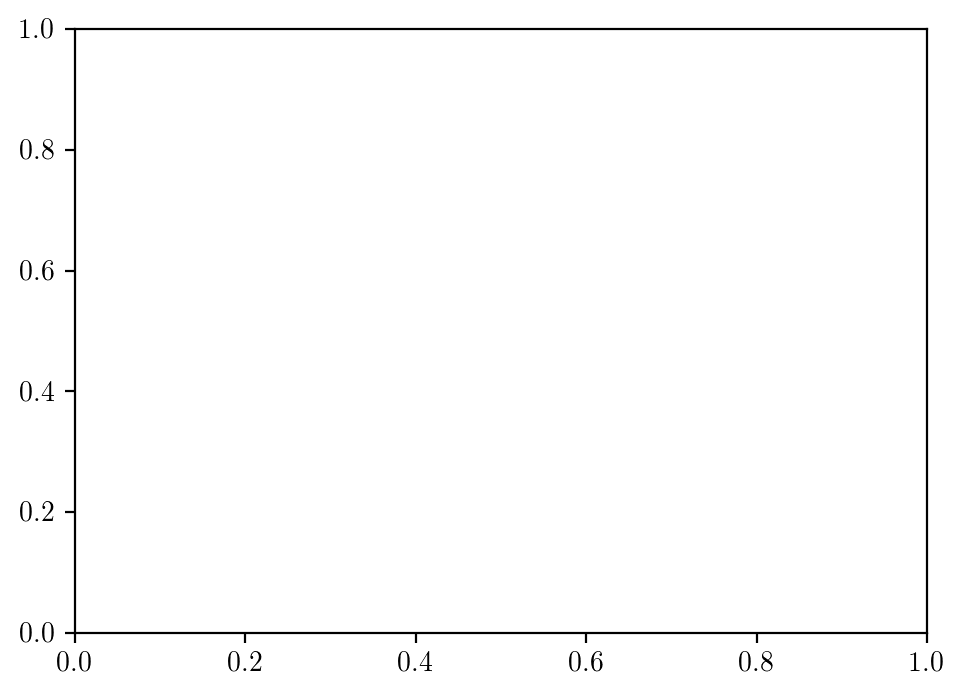

In [12]:
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig, ax1 = plt.subplots(1, 1, figsize=(5.5, 4), dpi=200)
for I in [30,40,50]:
    tag = f'{I}A/m^2'
    ax1.plot(reference[tag][:,0], reference[tag][:,1], "-", label='DFN {}{}'.format(tag,r"A/m^2"))
    ax1.plot(results[tag]['cathode_SOC'], results[tag]['voltage'], "--", label='cideMOD {}{}'.format(I,r"A/m^2"))
ax1.set_xlabel("Cathode SOC [-]")
ax1.set_ylabel("Voltage [V]")
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))